Hi guys, here we'll use a simple LSTM network and solve an univariate forecasting problems. We will use 1-step ahead forecasting approach. You can checkout my previous notebook, if you want to learn all the different type of sequence models and required required LSTM formations.

https://www.kaggle.com/amar09/paradigms-of-various-sequence-models-lstm

In [1]:
# load and plot dataset
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

shampoo_df = pd.read_csv('../input/sales-of-shampoo-over-a-three-year-period/sales-of-shampoo-over-a-three-ye.csv', header=0)
shampoo_df.dropna(inplace=True) # Droping the last row which contains NaN

In [2]:
# Month needs to be reformatted
shampoo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Month                                      36 non-null     object 
 1   Sales of shampoo over a three year period  36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 864.0+ bytes


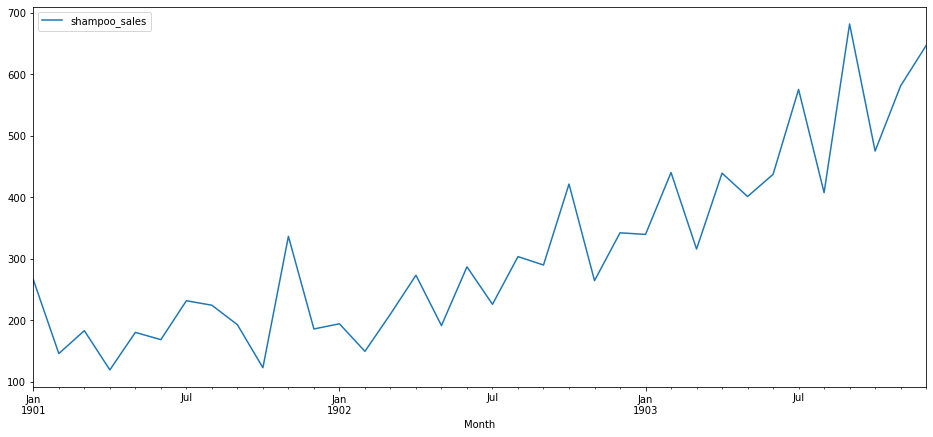

In [3]:
def preprocess_data(df):
    processed_df = df.rename(columns={
        'Sales of shampoo over a three year period': 'shampoo_sales'
    }).copy()

    processed_df['Month'] = pd.to_datetime(processed_df.Month.apply(lambda val: '190'+val))
    processed_df = processed_df.set_index('Month')

    return processed_df

processed_df = preprocess_data(shampoo_df)
# line plot
processed_df.plot(figsize=(16, 7));

- 1901 had no trend, there was only one spike at the end of the year. But later, from year 1902 we do have a trend.

- We see a significant spike at the end of each years. 

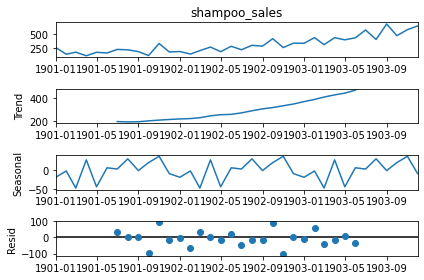

In [4]:
result = seasonal_decompose(processed_df.shampoo_sales, model='additive')
result.plot();

If you see Seasonal plot, there is a YoY shift in pattern.

## Data Preparation for LSTM:
Note that we need to prepare our input dat[](http://)a and expected output data and shape in a form of timesteps and features, as expected by LSTM model.

### 1. Transform the time series into a supervised learning problem

So unlike Classical Timeseries Statistical methods i.e. ARIMA, VAR etc, in LSTM, we are expected to train model in supervised fashon. So basically, we need to have a shifted series, working as an independent variables. We'll understand more as we move forward.

In [5]:
def get_supervised_independent_var(series):
    return series.shift(1).fillna(0).values

processed_df['X_shifted_sales'] = get_supervised_independent_var(processed_df.shampoo_sales)
processed_df.head()

,shampoo_sales,X_shifted_sales
Month,,
1901-01-01,266.0,0.0
1901-02-01,145.9,266.0
1901-03-01,183.1,145.9
1901-04-01,119.3,183.1
1901-05-01,180.3,119.3


### 2. Transform the time series data so that it is stationary.

Stationary data is easier to model and will very likely result in more skillful forecasts. Our sales data is clearly non-stationary, mainly because of increasing trend and sudden spikes and dips. So it will be better if we make our series stationary and later, after modelling, reverse transform to obtain the original series.

To remove trend, we can simply use differencing. that means:
> T(n) = T(n) - T(n-1)

In [6]:
def perform_diff(series):
    return pd.Series(series.diff().values)

processed_df['diff_shampoo_sales'] = perform_diff(processed_df['shampoo_sales']).values

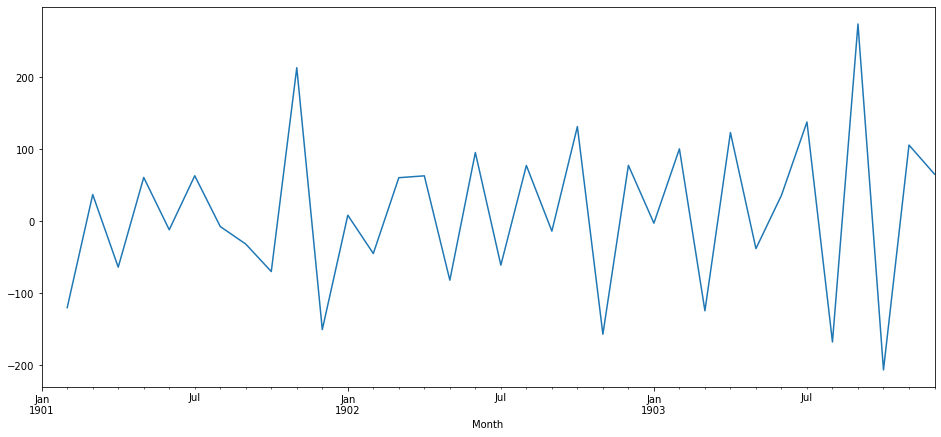

In [7]:
processed_df['diff_shampoo_sales'].plot(figsize=(16,7));

In [8]:
# invert differenced value
def invert_diff_transform(initial_actual_item, diff_series):
    return np.r_[initial_actual_item, diff_series].cumsum()

processed_df['invert_diff_sales'] = invert_diff_transform(processed_df['shampoo_sales'].iloc[0], processed_df['diff_shampoo_sales'].iloc[1:])
processed_df.head()

,shampoo_sales,X_shifted_sales,diff_shampoo_sales,invert_diff_sales
Month,,,,
1901-01-01,266.0,0.0,NaN,266.0
1901-02-01,145.9,266.0,-120.1,145.9
1901-03-01,183.1,145.9,37.2,183.1
1901-04-01,119.3,183.1,-63.8,119.3
1901-05-01,180.3,119.3,61.0,180.3


### 3. Transform the observations to have a specific scale.

Scaling is required to get reliable results in LSTM. The reason is our activation will return values in a range of 0-1 or -1 to 1, based on the choice of activation. For model, it's easier to learn and produce results if input is in a similar range. So here we are going to scale values between -1 and 1.

In [9]:
# transform scale
def scale_transform(series):
    series = series.reshape(len(series), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(series)
    return  scaler, scaler.transform(series)

scaler, processed_df['scaled_shampoo_sales'] = scale_transform(processed_df['shampoo_sales'].values)
processed_df.head()

,shampoo_sales,X_shifted_sales,diff_shampoo_sales,invert_diff_sales,scaled_shampoo_sales
Month,,,,,
1901-01-01,266.0,0.0,NaN,266.0,-0.478585
1901-02-01,145.9,266.0,-120.1,145.9,-0.905456
1901-03-01,183.1,145.9,37.2,183.1,-0.773236
1901-04-01,119.3,183.1,-63.8,119.3,-1.000000
1901-05-01,180.3,119.3,61.0,180.3,-0.783188


Note that, when we are preparing train and test set, we will have to use the train scaler on test set as well, so let's modify our function accoringly

In [10]:
# Simply use 
processed_df['inv_transformed_shampoo_sales'] = scaler.inverse_transform(processed_df['scaled_shampoo_sales'].values.reshape(-1, 1))
processed_df.head()

,shampoo_sales,X_shifted_sales,diff_shampoo_sales,invert_diff_sales,scaled_shampoo_sales,inv_transformed_shampoo_sales
Month,,,,,,
1901-01-01,266.0,0.0,NaN,266.0,-0.478585,266.0
1901-02-01,145.9,266.0,-120.1,145.9,-0.905456,145.9
1901-03-01,183.1,145.9,37.2,183.1,-0.773236,183.1
1901-04-01,119.3,183.1,-63.8,119.3,-1.000000,119.3
1901-05-01,180.3,119.3,61.0,180.3,-0.783188,180.3


In [11]:
# Modelling function for same

# scale train and test data to [-1, 1]
def scale_transform(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled


# invert transform
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

## LSTM Model Development

If you have seen my previous Notebook, I've explained about various sequence models i.e. one-to-one, many-to-one, one-to-many, and many-to-many. Here, we will go with a one-to-one model with a single feature/timestep, and a single timestep/sample.

We are going to use stacked LSTM to get a good performance. As we learnt earlier, in this case, first layer needs to have input_shape and it should return an output sequence going into the next LSTM layer.



In [12]:
def fit_lstm(train, batch_size, nb_epoch, neurons_l1):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_l1, 
                   batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()

    return model

In [13]:
def forecast(model, batch_size, row):
    x = row.reshape(1, 1, len(row))
    yhat = model.predict(x, batch_size=batch_size)
    return yhat[0,0]

### Putting it all together
Lets use all of these function in a structured and sequential way to prepare data, train LSTM, and do 1-step ahead forecasting.

In [14]:
# preprocess dataset.
model_df = preprocess_data(shampoo_df)

# Transforming the data to a supervised learning problem.
diff_series = perform_diff(model_df.shampoo_sales).dropna()

# Transforming the data to be stationary.
X_series = get_supervised_independent_var(diff_series)
supervised_values = pd.DataFrame([X_series, diff_series.values]).T.values

train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale_transform(train, test)

# Fitting a stateful LSTM network model to the training data.
lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=3000, neurons_l1=4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# Evaluating the static LSTM model on the test data.
lstm_model.predict(train_reshaped, batch_size=1)
# # Report the performance of the forecasts.

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast: so that statefulness can help LSTM model to learn from previous forecast as well 
    X_row, y_row = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast(lstm_model, 1, X_row)
    # invert scaling
    
    yhat = invert_scale(scaler, X_row, yhat)

    # invert differencing
    yhat = yhat + model_df.shampoo_sales.values[-1]
    print(yhat)
    # store forecast
    predictions.append(yhat)
    expected = model_df.shampoo_sales[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


23/23 [==============================] - 0s 1ms/step - loss: 0.0752
589.8161994963884
Month=1, Predicted=589.816199, Expected=339.700000
666.961390595138
Month=2, Predicted=666.961391, Expected=440.400000
563.4013749957085
Month=3, Predicted=563.401375, Expected=315.900000
718.5711281582713
Month=4, Predicted=718.571128, Expected=439.300000
546.9555166959763
Month=5, Predicted=546.955517, Expected=401.300000
661.4281257681548
Month=6, Predicted=661.428126, Expected=437.400000
624.9184656202793
Month=7, Predicted=624.918466, Expected=575.500000
500.5619605600833
Month=8, Predicted=500.561961, Expected=407.600000
691.9093290947378
Month=9, Predicted=691.909329, Expected=682.000000
297.84973800182337
Month=10, Predicted=297.849738, Expected=475.300000
614.5147439822555
Month=11, Predicted=614.514744, Expected=581.300000
440.482642430067
Month=12, Predicted=440.482642, Expected=646.900000


Test RMSE: 185.050


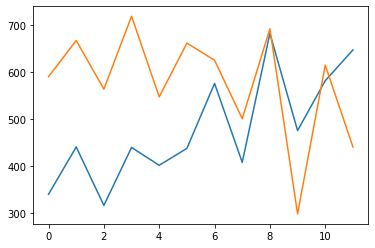

In [15]:
# report performance
rmse = sqrt(mean_squared_error(model_df.shampoo_sales.values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(model_df.shampoo_sales.values[-12:])
pyplot.plot(predictions)
pyplot.show()

It's not much good, but considering it as a basic model, it's a good starting point. There are many improvement areas in this method and modle building approach. Go ahead.. experiment and share your thoughts in comments.

**Reference:** <br>
    An amazing book by: Jason Brownlee
    [Deep Learning for Timeseries Forecasting](https://github.com/amdp-chauhan/datascience-ebooks-and-papers/blob/main/Deep%20Learning/deep-learning-for-time-series-forecasting-predict-the-future-with-mlps-cnns-and-lstms-in-python%20(Jason%20Brownlee).pdf)
    
